In [10]:
import os
import sys
import json
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from utils.model_utils import unwrap_model
from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict, enc_linear_param_dict

from data_module.data_module import ALDataModule_v1
from model.enc_classifier_model import AE1DClassifier, AE1DMaxPoolBNClassifierModel
from model.AE_model import AECNN1DBNModel, AE1DMaxPoolBNModel

In [11]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("-tl", "--train_limit_data", type=int, default=1000,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=5,
                    help=f"Number of class num use to train")

parser.add_argument("--model_name", type=str, default="4cnn_64",
                    help=f"Config name of model used for training")

parser.add_argument("--AE_ckpt_path", type=str, default="",
                    help=f"Config name of model used for training")

parser.add_argument("--linear_param", type=str, default="32",
                    help=f"Linear config name of model used for training")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [12]:
random_seed = 42
L.seed_everything(random_seed)

Seed set to 42


42

In [13]:
n_epochs = 4000000
patience = n_epochs//100

batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

model_name = f"{args.model_name}-8-{args.train_limit_data}-64"
AE_ckpt_abs_path = f"/nfs/ksdata/tran/HAR_AE/lightning_logs/11.1_AE/{model_name}/version_0/checkpoints/*.ckpt"
args.AE_ckpt_path = glob.glob(AE_ckpt_abs_path)[0]

log_save_dir = "lightning_logs"
log_save_name = f"15.1_enc_classify/{model_name}-{args.class_num}-{args.train_limit_data}-{args.random_seed}"

In [5]:
from model.AE_model import AE1D_simple, AECNN1DModel, AE1DMaxPoolBNModel
AE1DMaxPoolBNModel.load_from_checkpoint(args.AE_ckpt_path)

AE1DMaxPoolBNModel(
  (enc_cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(9,), stride=(3,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(8,), stride=(3,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 256, kernel_size=(7,), stride=(3,))
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (enc_linear): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dec_linear): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=T

In [7]:
data_module = ALDataModule_v1.load_from_checkpoint(args.AE_ckpt_path, dataset_path=dataset_path)
data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)

limit_and_set_train_data limit_number= 1000


In [8]:
L.seed_everything(args.random_seed)

net = AE1DMaxPoolBNClassifierModel(
    AE1DMaxPoolBN_ckpt_path=args.AE_ckpt_path,
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    linear_channel_param = enc_linear_param_dict[args.linear_param],
    out_features=args.class_num,
)

Seed set to 42


In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.utilities.model_summary import ModelSummary

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    )

trainer.fit(model=net, datamodule=data_module)
trainer_test_dict = trainer.logged_metrics

trainer.test(model=net, datamodule=data_module)
trainer_test_dict.update(trainer.logged_metrics)

for key in trainer_test_dict.keys():
    trainer_test_dict[key] = trainer_test_dict[key].item()

with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
    json.dump(trainer_test_dict, f)

with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

In [ ]:
checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/15.1_enc_classify/4cnn_64-8-1000-64-8-1000-42/version_0/checkpoints/sample_epoch=599-step=2400-val_loss=0.636736.ckpt"

data_module = ALDataModule_v1.load_from_checkpoint(checkpoint_path)
data_module.set_normal_train()
net = AE1DMaxPoolBNClassifierModel.load_from_checkpoint(checkpoint_path)

trainer = L.Trainer()

trainer.test(model=net, datamodule=data_module)
output = trainer.predict(model=net, datamodule=data_module)
pred = torch.argmax(torch.concat(output), dim=1)
gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))

In [25]:
args.eval_mode = 1

if args.eval_mode:
    log_save_dir = "lightning_logs"
    log_save_name = "15.1_enc_classify/{}-{}-{}-{}"
    args.random_seed = "42"
    result_save_dict = {}
    
    for args.model_name in "4cnn_128 4cnn_64".split(" "):
        for args.train_limit_data in "1000 5000".split(" "):
            for args.class_num in [5, 8]:
                model_name = f"{args.model_name}-8-{args.train_limit_data}-64"
                
                save_model_folder = log_save_name.format(model_name, args.class_num, args.train_limit_data, args.random_seed)
                save_model_dir = os.path.join(log_save_dir, save_model_folder)
                print(save_model_folder)
                
                weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                print(save_model_folder, weight)

                net = AE1DMaxPoolBNClassifierModel.load_from_checkpoint(weight)
                data_module = ALDataModule_v1.load_from_checkpoint(weight)
                data_module.set_normal_train()

                trainer = L.Trainer()
                trainer.test(model=net, datamodule=data_module, verbose=False)
                
                test_acc = trainer.logged_metrics["test_acc"]
                result_save_dict[save_model_folder] = test_acc


15.1_enc_classify/4cnn_128-8-1000-64-5-1000-42
15.1_enc_classify/4cnn_128-8-1000-64-5-1000-42 lightning_logs/15.1_enc_classify/4cnn_128-8-1000-64-5-1000-42/version_0/checkpoints/sample_epoch=409-step=1230-val_loss=0.195895.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 10/10 [00:00<00:00, 141.64it/s]
15.1_enc_classify/4cnn_128-8-1000-64-8-1000-42
15.1_enc_classify/4cnn_128-8-1000-64-8-1000-42 lightning_logs/15.1_enc_classify/4cnn_128-8-1000-64-8-1000-42/version_0/checkpoints/sample_epoch=409-step=1640-val_loss=0.606796.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 138.94it/s]
15.1_enc_classify/4cnn_128-8-5000-64-5-5000-42
15.1_enc_classify/4cnn_128-8-5000-64-5-5000-42 lightning_logs/15.1_enc_classify/4cnn_128-8-5000-64-5-5000-42/version_0/checkpoints/sample_epoch=179-step=2340-val_loss=0.129157.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 10/10 [00:00<00:00, 103.49it/s]
15.1_enc_classify/4cnn_128-8-5000-64-8-5000-42
15.1_enc_classify/4cnn_128-8-5000-64-8-5000-42 lightning_logs/15.1_enc_classify/4cnn_128-8-5000-64-8-5000-42/version_0/checkpoints/sample_epoch=249-step=5000-val_loss=0.484800.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 153.98it/s]
15.1_enc_classify/4cnn_64-8-1000-64-5-1000-42
15.1_enc_classify/4cnn_64-8-1000-64-5-1000-42 lightning_logs/15.1_enc_classify/4cnn_64-8-1000-64-5-1000-42/version_0/checkpoints/sample_epoch=469-step=1410-val_loss=0.187414.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 10/10 [00:00<00:00, 160.44it/s]
15.1_enc_classify/4cnn_64-8-1000-64-8-1000-42
15.1_enc_classify/4cnn_64-8-1000-64-8-1000-42 lightning_logs/15.1_enc_classify/4cnn_64-8-1000-64-8-1000-42/version_0/checkpoints/sample_epoch=599-step=2400-val_loss=0.637562.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 157.18it/s]
15.1_enc_classify/4cnn_64-8-5000-64-5-5000-42
15.1_enc_classify/4cnn_64-8-5000-64-5-5000-42 lightning_logs/15.1_enc_classify/4cnn_64-8-5000-64-5-5000-42/version_0/checkpoints/sample_epoch=249-step=3250-val_loss=0.136883.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 10/10 [00:00<00:00, 139.03it/s]
15.1_enc_classify/4cnn_64-8-5000-64-8-5000-42
15.1_enc_classify/4cnn_64-8-5000-64-8-5000-42 lightning_logs/15.1_enc_classify/4cnn_64-8-5000-64-8-5000-42/version_0/checkpoints/sample_epoch=479-step=9600-val_loss=0.501924.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████| 16/16 [00:00<00:00, 142.35it/s]


In [26]:
print(result_save_dict.keys())

dict_keys(['15.1_enc_classify/4cnn_128-8-1000-64-5-1000-42', '15.1_enc_classify/4cnn_128-8-1000-64-8-1000-42', '15.1_enc_classify/4cnn_128-8-5000-64-5-5000-42', '15.1_enc_classify/4cnn_128-8-5000-64-8-5000-42', '15.1_enc_classify/4cnn_64-8-1000-64-5-1000-42', '15.1_enc_classify/4cnn_64-8-1000-64-8-1000-42', '15.1_enc_classify/4cnn_64-8-5000-64-5-5000-42', '15.1_enc_classify/4cnn_64-8-5000-64-8-5000-42'])


15.1_enc_classify/4cnn_128-8-5000-64-5-5000-42
15.1_enc_classify/4cnn_64-8-5000-64-5-5000-42
15.1_enc_classify/4cnn_128-8-5000-64-8-5000-42
15.1_enc_classify/4cnn_64-8-5000-64-8-5000-42


/tmp/ipykernel_100109/473093920.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


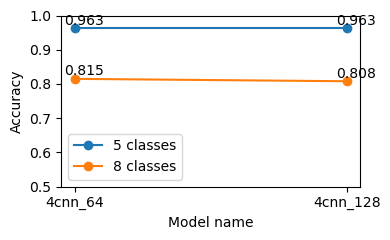

In [33]:
if args.eval_mode:
    fig, ax = plt.subplots(layout='constrained', figsize=(4, 2.5))
    args.random_seed = 42
    args.train_limit_data = "5000"
    
    for args.class_num in [5, 8]:
        x = []
        for args.model_name in "4cnn_128 4cnn_64".split(" "):
            model_name = f"{args.model_name}-8-{args.train_limit_data}-64"
            save_model_folder = log_save_name.format(model_name, args.class_num, args.train_limit_data, args.random_seed)
            print(save_model_folder)
            x.append(round(result_save_dict[save_model_folder].item(), 3))

        ax.plot(x, label=f"{args.class_num} classes", marker="o")
        for i, j in enumerate(x):
            ax.annotate(str(j),xy=(i-0.04,j+0.01))
        
    # ax.set_title(f'Accuracy of Classifier class_num={args.class_num} train_data_number={args.train_limit_data}')
    
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model name')
    
    ax.set_xticks([0, 1], ["4cnn_64", "4cnn_128"])
    ax.set_ylim(0.5, 1)
    
    ax.legend()
    plt.tight_layout()